# Black Hole Ray Tracing in Kerr Spacetime
# Bao "Tintin" Nguyen
# The University of Arizona
# August 2021

This program is adapted from Dr. Chi-Kwan Chan's [geodesic integrator](https://github.com/rndsrc/bhrad/blob/main/5.geodesic.ipynb) for non-spinning black holes.

I wrote this ray-tracing program for the Kerr (spinning) black hole case. More information on Kerr spacetime can be found on [Visser 2007](https://arxiv.org/abs/0706.0622) introductory paper.

This Jupyter Notebook is a brief summary of my exploratory work in 2021 in ray-tracing around black holes. Through this project, I learned general relativity and numerical methods and soon found my own research direction in Kerr naked singularity throughout 2022, culminating in my first-author [publication](https://iopscience.iop.org/article/10.3847/1538-4357/ace697) on the Astrophysical Journal!

In [ ]:
# We will use JAX for autodiff

from jax import numpy as np
from jax import jacfwd
from jax import jit
from jax.numpy        import dot
from jax.numpy.linalg import inv

from matplotlib import pyplot as plt

from tqdm import tqdm

## 1. The Cartesian Kerr-Schild coordinates

Thanks to autodiff, we only need to implement the metric for the Kerr-Schild coordinates $g_{\mu\nu}$. All other functions, such as the inverse metric $g^{\mu\nu}$ and the Jacobian of the metric $g_{\mu\nu,\alpha}$, can be computed automatically using JAX.

The Cartesian Kerr-Schild metric is expressed as follow, for indices (1, 2, 3, 4) representing (t, x, y, z):

$g_{\mu\nu} = η_{\mu\nu} + fl_{\mu}l_{\nu}$

$η_{\mu\nu}$ = diag(-1, 1, 1, 1) (Minkowski tensor)

$f = \large{\frac{2r^3}{r^4 + a^4z^2}}$ (In dimensionless units, G = M = 1)

$\textbf{l} = (l_t, l_x, l_y, l_z) = (1, \large{\frac{rx+ay}{r^2+a^2}, \large{\frac{ry-ax}{r^2+a^2}}, \large{\frac{z}{r}}} \normalsize)$

r is implicitly defined by: $\large{\frac{x^2+y^2}{r^2+a^2}} \normalsize + \large{\frac{z^2}{r^2}}\normalsize = 1$

From the above equation, $r = \pm \frac{1}{\sqrt{2}} (\pm \sqrt{...})$. The only r that works for the Kerr-Schild metric is when both $\pm$ are pluses (written in full form in the code).

In [ ]:
eta = np.asarray([[-1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]]) # Minkowski tensor

def metric(m):
    a = 0.9
    x = m[1]
    y = m[2]
    z = m[3]
    r = (1/np.sqrt(2))*(np.sqrt(-a**2 + np.sqrt(a**4 - 2*a**2*x**2 - 2*a**2*y**2 + 2*a**2*z**2 + x**4 + 2*x**2*y**2 + 2*x**2*z**2 + y**4 + 2*y**2*z**2 + z**4) + x**2 + y**2 + z**2))
    f = (2*r**3)/(r**4+a**2*z**2)
    l = np.asarray([1, (r*x+a*y)/(r**2+a**2), (r*y-a*x)/(r**2+a**2), z/r])
    return eta + f * l[:,np.newaxis] * l[np.newaxis,:]

def imetric(x):
    return inv(metric(x))

dmetric = jacfwd(metric)

## 2. Runge-Kutta-Fehlberg 4(5) method

Because the 4th-order Runge-Kutta method is unstable in integrating geodesics inside the event horizon due to large step sizes, the Runge-Kutta-Fehlberg 4(5) adaptive stepsize control with [Cash-Karp](https://dl.acm.org/doi/10.1145/79505.79507) parameters is implemented. For more reference on this method, read [Numerical Recipes for C](https://people.cs.clemson.edu/~dhouse/courses/817/papers/adaptive-h-c16-2.pdf).

In [ ]:
def RKF45(rhs, state, dt, epsilon):

    t = state[0]
    k1 = dt * rhs(state, t)
    k2 = dt * rhs(state + 1/5 * k1, t + 1/5 * dt)
    k3 = dt * rhs(state + 3/40 * k1 + 9/40 * k2, t + 3/10 * dt)
    k4 = dt * rhs(state + 3/10 * k1 - 9/10 * k2 + 6/5 * k3, t + 3/5 * dt)
    k5 = dt * rhs(state - 11/54 * k1 + 5/2 * k2 - 70/27 * k3 + 35/27 * k4, t + dt)
    k6 = dt * rhs(state + 1631/55296 * k1 + 175/512 * k2 + 575/13824 * k3 + 44275/110592 * k4 + 253/4096 * k5, t + 7/8 * dt)

    # Embedded 4th order
    state4 = state + 2825/27643 * k1 + 18575/48384 * k3 + 13525/55296 * k4 - 277/14336 * k5 + 1/4 * k6

    # 5th order
    state5 = state + 37/378 * k1 + 250/621 * k3 + 125/594 * k4 + 512/1771 * k6

    R = np.linalg.norm(state5 - state4) # Truncation error

    multiplier = 0.9*(epsilon/R)**1/4

    # If the truncation error is small, return the 4th order estimation and update the stepsize
    if R <= epsilon:
        dt = dt * multiplier
        return state4
    # If the truncation error is big, repeat the process with a smaller stepsize
    else:
        return RKF45(rhs, state, dt * multiplier, epsilon)

## 3. The Geodesic Equation

The geodesic equation is expressed in the form derived by this [Chan et al. 2018](https://iopscience.iop.org/article/10.3847/1538-4357/aadfe5/meta).

In [ ]:
def rhs(state, t):
    x  = np.append(t, state[1:4])
    v  = state[4:]

    ig = imetric(x)
    jg = dmetric(x)
    a  = (-       dot(ig, dot(dot(jg, v), v))
          + 0.5 * dot(ig, dot(v, dot(v, jg))))

    return np.concatenate([v, a])

## 4.1. a = 1, initial trajectory is parallel to the ring singularity

The black hole spin, denoted as "a", is normalized such that a = 1 is the maximally spinning black hole

In [ ]:
dt = 0.05 # Step size
N  = 2000 # Number of integration steps
s0 = np.array([
    0, 5, 1.2, 1.2,
    1, -1, 0, 0,
], dtype=np.float32) # Initial conditions

# Construct the array to hold the results

states = [s0]

# Integrate the geodesic equation

for i in tqdm(range(N)):
    states.append(RKF45(rhs, states[-1], dt, 0.01))

S = np.array(states)
X = S[:,:4]
V = S[:,4:]
a = 1

100%|██████████| 2000/2000 [26:41<00:00,  1.25it/s]


In [ ]:
np.all(np.diff(X[:, 0]) > 0)

DeviceArray(True, dtype=bool)

In this case, time always moves forward.

XY-PLANE PLOT:


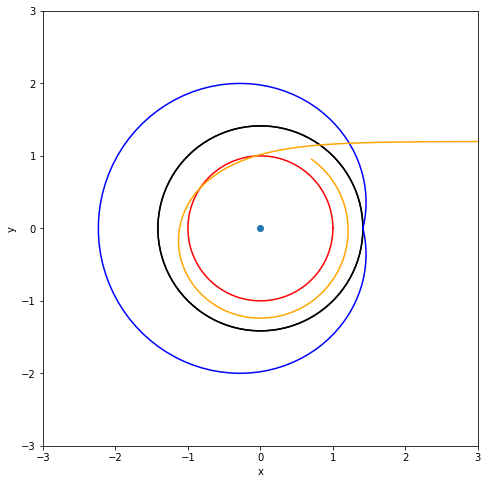

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(16,8))

a = 1
theta = np.linspace(0, np.pi, 100)
phi = np.linspace(0, 2 * np.pi, 100)
r_outer = np.sqrt(2*np.sqrt(1-a**2)+2)
r_inner = np.sqrt(-2*np.sqrt(1-a**2)+2)
e_outer = np.sqrt(-a**2*(np.cos(theta))**2 + a**2 + 2*np.sqrt(1-a**2*(np.cos(theta))**2) + 2)

ax.plot(a * np.cos(phi), a * np.sin(phi), color = "red")
ax.plot(r_outer * np.cos(phi), r_outer * np.sin(phi), color='black') # outer event horizon
ax.plot(r_inner * np.cos(phi), r_inner * np.sin(phi), color='black') # inner event horizon
ax.plot(e_outer * np.cos(phi), e_outer * np.sin(phi), color='blue') # outer ergosphere
ax.plot(X[:,1], X[:,2], color = "orange")

ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.scatter(0,0)
ax.set_aspect('equal')

We can see that a light ray that is initially sent on the equatorial plane (parallel to the ring singularity, denoted in red) remains on the equatorial plane.

The blue shaded region denotes the black hole ergosphere, where the light ray is forced to be spinning with the black hole.

The dark region denotes the interior of the black hole event horizon, where nothing can escape. Here, we see that the light ray is trapped within the event horizon.

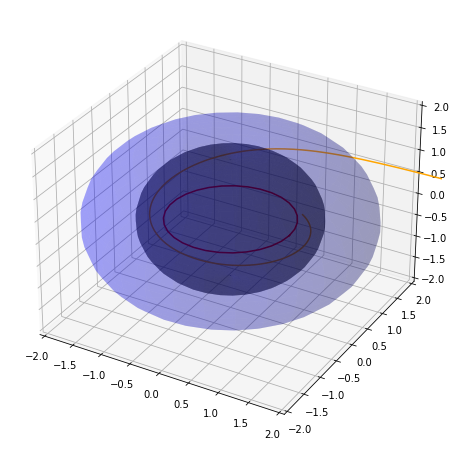

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
a = 1
phi = np.linspace(0, 2 * np.pi, 32)
theta = np.linspace(0, np.pi, 32)
z = np.linspace(-0.5, 0.5, 32)
r_outer = (1/a)*np.sqrt(a**2*z**2 + 2*z**2*np.sqrt(1-a**2) + 2*a**2*np.sqrt(1-a**2) + 2*a**2 - 2*z**2)
r_inner = (1/a)*np.sqrt(a**2*z**2 - 2*z**2*np.sqrt(1-a**2) - 2*a**2*np.sqrt(1-a**2) + 2*a**2 - 2*z**2)
e_outer = (1/a)*np.sqrt(-a**4*(np.cos(theta))**2 + a**4 + a**2*z**2*(1/np.cos(theta))**2 + 2*z**2*(1/np.cos(theta))**4*np.sqrt(1-a**2*(np.cos(theta))**2) + 2*a**2*np.sqrt(1-a**2*(np.cos(theta))**2) + 2*a**2 - 2*z**2*(1/np.cos(theta))**4)

def sphere(r, color, alpha):
    x = r * np.outer(np.cos(phi), np.sin(theta))
    y = r * np.outer(np.sin(phi), np.sin(theta))
    z = r * np.outer(np.ones(np.size(phi)), np.cos(theta))
    ax.plot_surface(x, y, z, color = color, alpha = alpha)

fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(projection='3d')
ax.plot3D(a*np.cos(phi), a*np.sin(phi), np.zeros(phi.size), color = "red") # ring singularity
ax.plot3D(X[:, 1], X[:, 2], X[:, 3], color = "orange")
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_zlim(-2, 2)
sphere(r_outer, "black", 0.2) # outer event horizon
sphere(r_inner, "black", 0.2) # inner event horizon
sphere(e_outer, "blue", 0.2) # outer ergosphere

## 4.2. a = 1, initial trajectory is 45o above the ring singularity

In [ ]:
dt = 0.05 # Step size
N  = 3000 # Number of integration steps
s0 = np.array([
    0, 5, 0.5, 5,
    1, -1, 0, -1,
], dtype=np.float32) # Initial conditions

# Construct the array to hold the results

states = [s0]

# Integrate the geodesic equation

for i in tqdm(range(N)):
    states.append(RKF45(rhs, states[-1], dt, 0.1))

S = np.array(states)
X = S[:,:4]
V = S[:,4:]
a = 1

100%|██████████| 3000/3000 [40:40<00:00,  1.23it/s]


In [ ]:
np.all(np.diff(X[:, 0]) > 0)

DeviceArray(True, dtype=bool)

In this case, time always moves forward.

XY-PLANE PLOT:

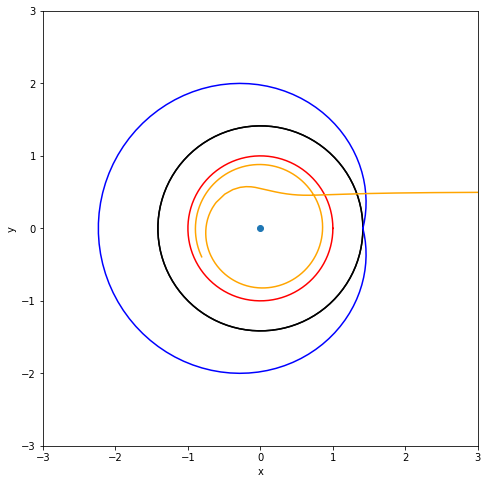

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(16,8))

a = 1
theta = np.linspace(0, np.pi, 100)
phi = np.linspace(0, 2 * np.pi, 100)
r_outer = np.sqrt(2*np.sqrt(1-a**2)+2)
r_inner = np.sqrt(-2*np.sqrt(1-a**2)+2)
e_outer = np.sqrt(-a**2*(np.cos(theta))**2 + a**2 + 2*np.sqrt(1-a**2*(np.cos(theta))**2) + 2)

ax.plot(a * np.cos(phi), a * np.sin(phi), color = "red")
ax.plot(r_outer * np.cos(phi), r_outer * np.sin(phi), color='black') # outer event horizon
ax.plot(r_inner * np.cos(phi), r_inner * np.sin(phi), color='black') # inner event horizon
ax.plot(e_outer * np.cos(phi), e_outer * np.sin(phi), color='blue') # outer ergosphere
ax.plot(X[:,1], X[:,2], color = "orange")

ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.scatter(0,0)
ax.set_aspect('equal')

3D PLOT:

When the light ray is sent into the black hole at an inclination, it can "go through" the singularity.

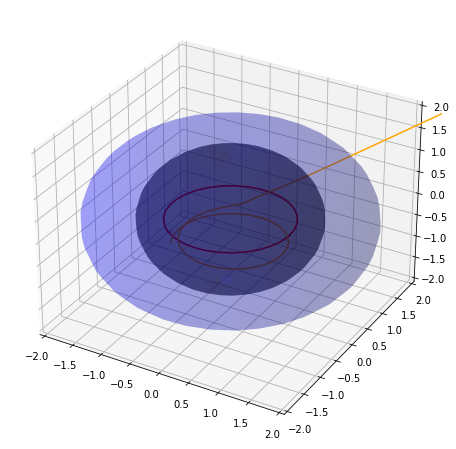

In [ ]:
a = 1
phi = np.linspace(0, 2 * np.pi, 32)
theta = np.linspace(0, np.pi, 32)
z = np.linspace(-0.5, 0.5, 32)
r_outer = (1/a)*np.sqrt(a**2*z**2 + 2*z**2*np.sqrt(1-a**2) + 2*a**2*np.sqrt(1-a**2) + 2*a**2 - 2*z**2)
r_inner = (1/a)*np.sqrt(a**2*z**2 - 2*z**2*np.sqrt(1-a**2) - 2*a**2*np.sqrt(1-a**2) + 2*a**2 - 2*z**2)
e_outer = (1/a)*np.sqrt(-a**4*(np.cos(theta))**2 + a**4 + a**2*z**2*(1/np.cos(theta))**2 + 2*z**2*(1/np.cos(theta))**4*np.sqrt(1-a**2*(np.cos(theta))**2) + 2*a**2*np.sqrt(1-a**2*(np.cos(theta))**2) + 2*a**2 - 2*z**2*(1/np.cos(theta))**4)

def sphere(r, color, alpha):
    x = r * np.outer(np.cos(phi), np.sin(theta))
    y = r * np.outer(np.sin(phi), np.sin(theta))
    z = r * np.outer(np.ones(np.size(phi)), np.cos(theta))
    ax.plot_surface(x, y, z, color = color, alpha = alpha)

fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(projection='3d')
ax.plot3D(a*np.cos(phi), a*np.sin(phi), np.zeros(phi.size), color = "red") # ring singularity
ax.plot3D(X[:, 1], X[:, 2], X[:, 3], color = "orange")
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_zlim(-2, 2)
sphere(r_outer, "black", 0.2) # outer event horizon
sphere(r_inner, "black", 0.2) # inner event horizon
sphere(e_outer, "blue", 0.2) # outer ergosphere

## 4.3. a > 1, ring singularity

In 2021, as I experimented with my ray-tracing code, I wondered, "What happens if I keep increasing the black hole spin?"

To my surprise, if the black hole spin exceeds a theoretical limit (a > 1), the event horizon vanishes, leaving behind a *naked singularity*!

This theoretical phenomena was long discovered, but this "eureka" soon evolved into my own research focus throughout 2022, culminating in my first-author [publication](https://iopscience.iop.org/article/10.3847/1538-4357/ace697) on the Astrophysical Journal!

Below is a summary of the "eureka" moment that sparked my new research direction in 2022.

In [ ]:
dt = 0.05 # Step size
N  = 2000 # Number of integration steps
s0 = np.array([
    0, 5, 0.5, 5,
    1, -1, 0, -1,
], dtype=np.float32) # Initial conditions

# Construct the array to hold the results

states = [s0]

# Integrate the geodesic equation

for i in tqdm(range(N)):
    states.append(RKF45(rhs, states[-1], dt, 0.1))

S = np.array(states)
X = S[:,:4]
V = S[:,4:]

100%|██████████| 2000/2000 [14:48<00:00,  2.25it/s]


In [ ]:
np.all(np.diff(X[:, 0]) > 0)

DeviceArray(True, dtype=bool)

In this case, time always moves forward.

XY-PLANE PLOT:

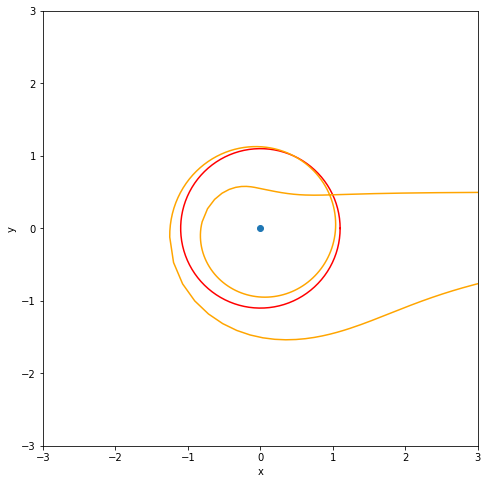

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(16,8))

a = 1.1
theta = np.linspace(0, np.pi, 100)
phi = np.linspace(0, 2 * np.pi, 100)

ax.plot(a * np.cos(phi), a * np.sin(phi), color = "red")
ax.plot(X[:,1], X[:,2], color = "orange")

ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.scatter(0,0)
ax.set_aspect('equal')

3D PLOT:

(-2.0, 2.0)

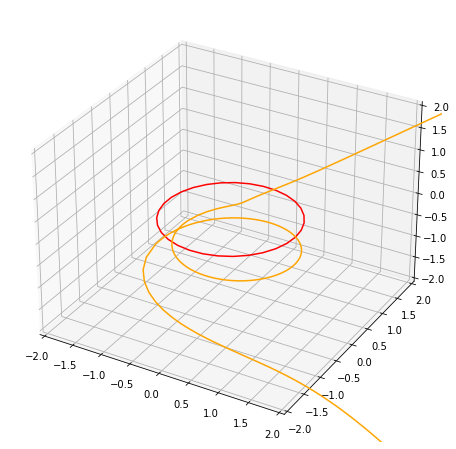

In [ ]:
a = 1.1
phi = np.linspace(0, 2 * np.pi, 32)
theta = np.linspace(0, np.pi, 32)
z = np.linspace(-0.5, 0.5, 32)
r_outer = (1/a)*np.sqrt(a**2*z**2 + 2*z**2*np.sqrt(1-a**2) + 2*a**2*np.sqrt(1-a**2) + 2*a**2 - 2*z**2)
r_inner = (1/a)*np.sqrt(a**2*z**2 - 2*z**2*np.sqrt(1-a**2) - 2*a**2*np.sqrt(1-a**2) + 2*a**2 - 2*z**2)
e_outer = (1/a)*np.sqrt(-a**4*(np.cos(theta))**2 + a**4 + a**2*z**2*(1/np.cos(theta))**2 + 2*z**2*(1/np.cos(theta))**4*np.sqrt(1-a**2*(np.cos(theta))**2) + 2*a**2*np.sqrt(1-a**2*(np.cos(theta))**2) + 2*a**2 - 2*z**2*(1/np.cos(theta))**4)

def sphere(r, color, alpha):
    x = r * np.outer(np.cos(phi), np.sin(theta))
    y = r * np.outer(np.sin(phi), np.sin(theta))
    z = r * np.outer(np.ones(np.size(phi)), np.cos(theta))
    ax.plot_surface(x, y, z, color = color, alpha = alpha)

fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(projection='3d')
ax.plot3D(a*np.cos(phi), a*np.sin(phi), np.zeros(phi.size), color = "red") # ring singularity
ax.plot3D(X[:, 1], X[:, 2], X[:, 3], color = "orange")
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_zlim(-2, 2)


Comment: The photon goes through the ring, experiences some frame dragging, then exits. There's no event horizon, so the light ray can escape! This might have some implications for the observational signature!

## 4.4. a < 1, double horizons

When spin a < 1, the black hole has 2 event horizons: the inner and outer horizons

In [ ]:
dt = 0.05 # Step size
N  = 4000 # Number of integration steps
s0 = np.array([
    0, 5, 0.5, 5,
    1, -1, 0, -1,
], dtype=np.float32) # Initial conditions

# Construct the array to hold the results

states = [s0]

# Integrate the geodesic equation

for i in tqdm(range(N)):
    states.append(RKF45(rhs, states[-1], dt, 0.1))

S = np.array(states)
X = S[:,:4]
V = S[:,4:]

100%|██████████| 4000/4000 [53:05<00:00,  1.26it/s]


XY-PLANE PLOT:

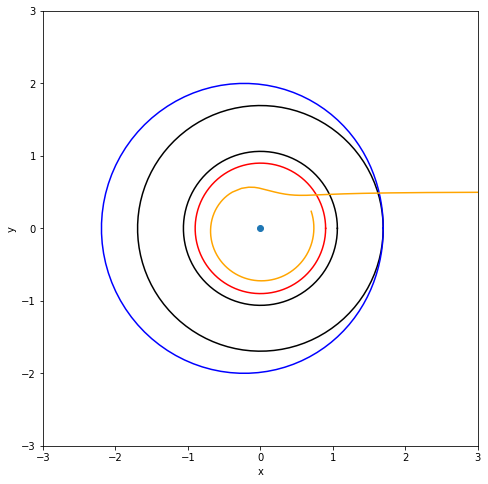

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(16,8))

a = 0.9
theta = np.linspace(0, np.pi, 100)
phi = np.linspace(0, 2 * np.pi, 100)
r_outer = np.sqrt(2*np.sqrt(1-a**2)+2)
r_inner = np.sqrt(-2*np.sqrt(1-a**2)+2)
e_outer = np.sqrt(-a**2*(np.cos(theta))**2 + a**2 + 2*np.sqrt(1-a**2*(np.cos(theta))**2) + 2)

ax.plot(a * np.cos(phi), a * np.sin(phi), color = "red")
ax.plot(r_outer * np.cos(phi), r_outer * np.sin(phi), color='black') # outer event horizon
ax.plot(r_inner * np.cos(phi), r_inner * np.sin(phi), color='black') # inner event horizon
ax.plot(e_outer * np.cos(phi), e_outer * np.sin(phi), color='blue') # outer ergosphere
ax.plot(X[:,1], X[:,2], color = "orange")

ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.scatter(0,0)
ax.set_aspect('equal')

3D PLOT:

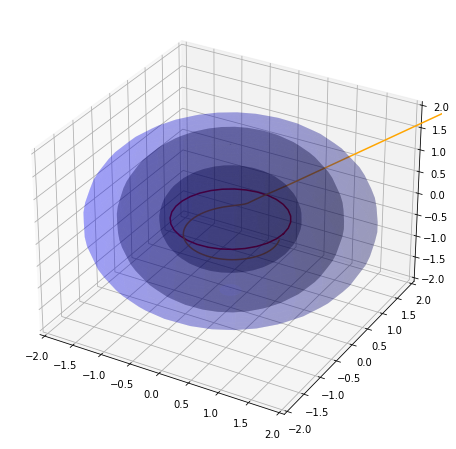

In [ ]:
a = 0.9
phi = np.linspace(0, 2 * np.pi, 32)
theta = np.linspace(0, np.pi, 32)
z = np.linspace(-0.5, 0.5, 32)
r_outer = (1/a)*np.sqrt(a**2*z**2 + 2*z**2*np.sqrt(1-a**2) + 2*a**2*np.sqrt(1-a**2) + 2*a**2 - 2*z**2)
r_inner = (1/a)*np.sqrt(a**2*z**2 - 2*z**2*np.sqrt(1-a**2) - 2*a**2*np.sqrt(1-a**2) + 2*a**2 - 2*z**2)
e_outer = (1/a)*np.sqrt(-a**4*(np.cos(theta))**2 + a**4 + a**2*z**2*(1/np.cos(theta))**2 + 2*z**2*(1/np.cos(theta))**4*np.sqrt(1-a**2*(np.cos(theta))**2) + 2*a**2*np.sqrt(1-a**2*(np.cos(theta))**2) + 2*a**2 - 2*z**2*(1/np.cos(theta))**4)

def sphere(r, color, alpha):
    x = r * np.outer(np.cos(phi), np.sin(theta))
    y = r * np.outer(np.sin(phi), np.sin(theta))
    z = r * np.outer(np.ones(np.size(phi)), np.cos(theta))
    ax.plot_surface(x, y, z, color = color, alpha = alpha)

fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(projection='3d')
ax.plot3D(a*np.cos(phi), a*np.sin(phi), np.zeros(phi.size), color = "red") # ring singularity
ax.plot3D(X[:, 1], X[:, 2], X[:, 3], color = "orange")
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_zlim(-2, 2)
sphere(r_outer, "black", 0.2) # outer event horizon
sphere(r_inner, "black", 0.2) # inner event horizon
sphere(e_outer, "blue", 0.2) # outer ergosphere